# Dynamically Adaptable Virtual Machines for Sustainable Websites

This notebook aim at providing the analysis process of the HTML VM enenergy consumption and gains

## Imports

In [1]:
import json 
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import gmean
from math import sqrt
import scipy.stats as stats
import scipy.special as special

## Website Carbon

This script aim to provide the energy consumption and carbon impact of website requests.

### Constants

In [2]:
# Path to the folder containing HAR files
HAR_FOLDER = "./Data_Transfer/"

# Algorithm constants
KWG_PER_GB = 1.805
KWH_PER_BYTE = KWG_PER_GB / 1073741824
J_PER_KWH = 1000 * 3600
RETURNING_VISITOR_PERCENTAGE = 0.75
FIRST_TIME_VIEWING_PERCENTAGE = 0.25
PERCENTAGE_OF_DATA_LOADED_ON_SUBSEQUENT_LOAD = 0.02
CARBON_PER_KWG_GRID = 475
CARBON_PER_KWG_RENEWABLE = 33.4
PERCENTAGE_OF_ENERGY_IN_DATACENTER = 0.1008
PERCENTAGE_OF_ENERGY_IN_TRANSMISSION_AND_END_USER = 0.8992
CO2_GRAMS_TO_LITRES = 0.5562

# Data access constants
NORMAL = 0
ADAPTED = 1

### Functions

adjustDataTranfert : calculate the average transfert size considering caching capacity of web browser

energyConsumption : calculate the energy consumption from the tranfert size

getCo2Grid : calculate the equivalent CO2 when using a classic host

getCo2Renewable : calculate the equivalent CO2 when using a green host

co2ToLitres : convert CO2 mass to volume

getStatistics : aggregate previous statistics

cleanerThan : compare to other sites

In [3]:
def adjustDataTransfer(val): 
    out =  val * RETURNING_VISITOR_PERCENTAGE 
    out += val * PERCENTAGE_OF_DATA_LOADED_ON_SUBSEQUENT_LOAD * FIRST_TIME_VIEWING_PERCENTAGE
    return out

In [4]:
def energyConsumption(bytes): 
    return bytes * KWH_PER_BYTE;

In [5]:
def getCo2Grid(energy):
    return energy * CARBON_PER_KWG_GRID;

In [6]:
def getCo2Renewable(energy):
    out =  energy * PERCENTAGE_OF_ENERGY_IN_DATACENTER * CARBON_PER_KWG_RENEWABLE
    out += energy * PERCENTAGE_OF_ENERGY_IN_TRANSMISSION_AND_END_USER * CARBON_PER_KWG_GRID
    return out

In [7]:
def co2ToLitres(co2):
    return co2 * CO2_GRAMS_TO_LITRES;

In [8]:
def getStatistics(bytes):
    bytesAdjusted = adjustDataTransfer(bytes);
    energy = energyConsumption(bytesAdjusted);
    co2Grid = getCo2Grid(energy);
    co2Renewable = getCo2Renewable(energy);

    return {
        'adjustedBytes' : bytesAdjusted,
        'energy' : energy,
        'co2' : {
            'grid' : {
                'grams' : co2Grid,
                'litres': co2ToLitres(co2Grid)
            },
            'renewable' : {
                'grams' : co2Renewable,
                'litres' : co2ToLitres(co2Renewable)
            }
        }
    }

In [9]:
def cleanerThan(co2):
    # This array needs to be updated periodically with new data. This was
    # originally calculated with a database query but that was too slow at
    # scale. We can look in to writing a cron job that will generate and export
    # from the database once a month, that is then loaded in this file.

    # This array was last generated with rankings/index.php on 27/01/2020
    percentiles = [0.00126957622871866,0.004035396817140881,0.012595561048805604,0.023304715095553624,0.036438786824583,0.050362397616329,0.064014899640461,0.077739052678226,0.092126836186624,0.10757047217165,0.125027739890344,0.140696302455872,0.15929047315768,0.177734818869488,0.19581439489964,0.21422507361825607,0.232736823359142,0.246082174332492,0.264348156430992,0.28306902111392,0.30180466482882,0.320295382181204,0.33950686554985604,0.360111566931774,0.38114308483189,0.40185357017186396,0.42035354145420606,0.4393550630164101,0.458541453493762,0.47918906703882,0.499654077413412,0.521285635156174,0.5405494875603221,0.56161428648152,0.58238456980151,0.604316363860106,0.6256429617179278,0.6478269528228661,0.6691073942929641,0.68867154881184,0.7103787320465419,0.7331362414675519,0.7562483364936439,0.780892842691506,0.80396830015467,0.8269877794821401,0.85060546199698,0.874387816802448,0.899691291111552,0.92324242726303,0.9511826145960923,0.976586133398462,1.002258239346,1.02822903453074,1.0566669431626,1.08448123862022,1.1130571798008,1.1446436812039398,1.17548103245766,1.2075157831423,1.2419762271574795,1.27780212823068,1.31343697309996,1.3535322129548801,1.3963404885134,1.43538821676594,1.4786819721653202,1.52287253339568,1.5710404823845998,1.6176354301871,1.6627899659050596,1.71503331661196,1.7731704594157403,1.8271314036959998,1.8888232850004,1.9514501162933802,2.01843049142384,2.08929918752446,2.1680425684300615,2.2538809089543,2.347435716407921,2.44446281762258,2.551568006854039,2.6716183180923796,2.8030676779506,2.947526052684458,3.1029734241542397,3.2801577012624605,3.4659335564053406,3.6858566410374,3.9539822299055203,4.2833358140900835,4.686514950833381,5.167897618200399,5.7413021838327,6.52500051792535,7.628926245040858,9.114465674521588,12.30185529895519,92.584834950345]

    for i in range(0, 100):
        value = percentiles[i]
        if(co2 < value):
            return (100 - i)
    return 0

In [10]:
def printInfo(bytesNb):
  stats = getStatistics(bytesNb)
  energy = stats["energy"]
  grams = stats["co2"]["grid"]["grams"]
  greenerThan = cleanerThan(grams)
  if(greenerThan > 50):
      print("\033[1;32;48mThis page is cleaner than " + str(greenerThan) + "% of web pages tested\033[00m")
  else:
      print("\033[1;31;48mThis page is dirtier than " + str(99-greenerThan) + "% of web pages tested\033[00m")
  print("\033[01m"+str(round(grams,3)) + "g of CO2\033[00m is produced every time someone visits this web page ("+str(round(energy,4))+" KWH)")

### Data

Build the datastructure from the HAR files

In [11]:
HAR_FILES = glob.glob(HAR_FOLDER+"*.har")

data = []

for HAR_FILE in HAR_FILES:
    normal = open(HAR_FILE, "r")
    adapted = open(HAR_FILE+".adapted", "r")
    if normal.mode == 'r' and adapted.mode == 'r':
        contents = normal.read()
        jsonObj = json.loads(contents)
        normal_bytes = 0
        for r in jsonObj["log"]["entries"]:
            normal_bytes += r["response"]["bodySize"]

        contents = adapted.read()
        jsonObj = json.loads(contents)
        adapted_bytes = 0
        for r in jsonObj["log"]["entries"]:
            adapted_bytes += r["response"]["bodySize"]
        parts = HAR_FILE.split("/")
        entry = {
            "name": parts[-1], 
            "transferSizes" : [normal_bytes, adapted_bytes],
            "energy" : [energyConsumption(normal_bytes) * J_PER_KWH, energyConsumption(adapted_bytes) * J_PER_KWH]
        }
        data.append(entry)

## Approach consumption



### Node.js Proxy consumption

In [12]:
proxy_consumption = pd.read_csv('./proxy/NodeProxy.csv', header=None) 
proxy_consumption = proxy_consumption.groupby(0).sum()
proxy_consumption = proxy_consumption / 100

### HTML VM Consumption

In [13]:
vm_consumption = pd.read_csv('./proxy/HTML.csv', header=None) 
vm_consumption = vm_consumption.groupby(0).sum()
vm_consumption = vm_consumption / 10

In [14]:
approach_consumption = []
for index, row in proxy_consumption.iterrows():
    parts = index.split(".")
    entry = { "name" : parts[0], "energy" : row[1]}
    approach_consumption.append(entry)
for index, row in vm_consumption.iterrows():
    parts = index.split(".")
    entry = { "name" : parts[0], "energy" : row[1]}
    approach_consumption.append(entry)
    
approach_consumption = pd.DataFrame(approach_consumption)

In [15]:
approach_consumption = approach_consumption.groupby("name").sum()
approach_average_consumption = gmean(approach_consumption.loc[:,"energy"])
print("Geometric mean of energy consumption = " + str(approach_average_consumption))

Geometric mean of energy consumption = 68.61082178391608


## Statistics


In [16]:
def cohend(d1, d2):
    n1, n2 = len(d1), len(d2)
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    u1, u2 = np.mean(d1), np.mean(d2)
    return (u1 - u2) / s

### Evaluate the effect of the approach

In [17]:
control= []
test = []
for entry in data:
    control.append(entry["energy"][NORMAL])
    test.append(entry["energy"][ADAPTED] + approach_average_consumption)
dfControl = pd.DataFrame(control)
dfTest  = pd.DataFrame(test)

In [18]:
print("Control Group")
dfControl.describe()

Control Group


,0
count,45.000000
mean,25762.320914
std,21795.906832
min,1225.022273
25%,10053.600602
50%,25756.101614
75%,29630.597278
max,113707.568955


In [19]:
print("Test Group")
dfTest.describe()

Test Group


,0
count,45.000000
mean,7867.391112
std,9773.922140
min,348.576144
25%,1876.875020
50%,3642.946527
75%,9453.397979
max,43804.898555


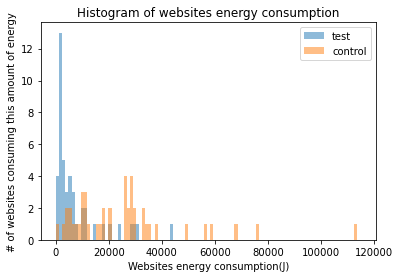

In [20]:
bins = np.linspace(100, 115000, 100)

plt.hist(test, bins, alpha=0.5, label='test')
plt.hist(control, bins, alpha=0.5, label='control')
plt.legend(loc='upper right')
plt.title('Histogram of websites energy consumption')
plt.xlabel('Websites energy consumption(J)')
plt.ylabel('# of websites consuming this amount of energy')
plt.show()

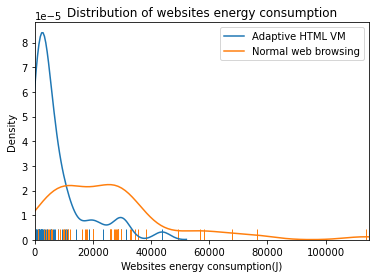

In [21]:
plt.xlim(0, 115000)
ax = sns.distplot(test, hist=False, rug=True, label="Adaptive HTML VM");
ax.set_title('Distribution of websites energy consumption')
ax.set_xlabel('Websites energy consumption(J)')
ax.set_ylabel('Density')
sns.distplot(control, hist=False, rug=True, label="Normal web browsing");

In [22]:
print("Effect size (Cohen's d) : " + str(cohend(control, test)))
stats.ttest_ind(a=control,b=test,equal_var=False)

Effect size (Cohen's d) : 1.0594549561745572


Ttest_indResult(statistic=5.025436109798207, pvalue=4.676455520870763e-06)

#### Discussion
With a mean of 25762.32 Joules for the control group (normal web browsing) and 7867.39 Joules for the test group (adaptive web browsing) and a p-value of 4.68x10^-6 we conclude to a statistically significant difference between the two groups. Moreover, we compute the effect size in the form of the cohen's d in order to quantify this difference. With a value for the cohen's d around 1, we conclude that our approach yield a large effect on the web browsing energy consumption.

### Evaluate the average ratio of consumed energy

In [23]:
ratios= []
for entry in data:
    ratio = 1 - (entry["energy"][ADAPTED] + approach_average_consumption) / entry["energy"][NORMAL]
    print("{:<22}".format(entry["name"]) + " : " + ("" if ratio < 0 else " ") + str(ratio))
    ratios.append(ratio)
dfRatios = pd.DataFrame(ratios)
dfRatios.rename(columns={0:"Energy consumption ratio"}, inplace=True)

tripadvisor.har        :  0.9502624908658479
cnet.har               :  0.9597697215234957
microsoft.har          :  0.6446405456732518
globo.har              :  0.7889168964224141
fandom.har             :  0.9288959718128857
webmd.har              :  0.5630958547016764
britannica.har         :  0.9283621885808455
thesaurus.har          :  0.9438100843057541
ebay.har               :  0.7738106471914337
cricbuzz.har           :  0.7612020508684165
espncricinfo.har       :  0.7599236450974477
genius.har             :  0.8624504306315708
rottentomatoes.har     :  0.7332986386619709
nytimes.har            :  0.4780709146415566
ytmp3.har              :  0.7334933102845678
apple.har              :  0.35446465120392023
reddit.har             :  0.926285825260249
espn.har               :  0.9278444043100721
y2mate.har             : -0.08677476648909965
dictionary.har         :  0.9186287386460963
unsplash.har           :  0.5557426458460382
urbandictionary.har    :  0.4993728864623095
amazon.ha

In [24]:
dfRatios.describe()

,Energy consumption ratio
count,45.000000
mean,0.638008
std,0.319939
min,-0.086775
25%,0.499373
50%,0.733493
75%,0.907497
max,0.971595


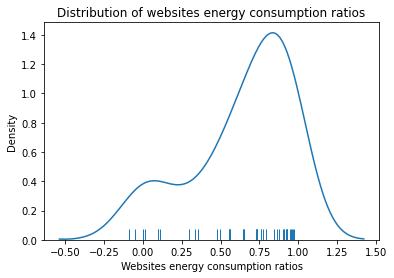

In [25]:
ax = sns.rugplot(ratios)
ax.set_title('Distribution of websites energy consumption ratios')
ax.set_xlabel('Websites energy consumption ratios')
ax.set_ylabel('Density')
ax = sns.kdeplot(ratios)


In [26]:
mean = np.mean(ratios)
lo, hi = stats.t.interval(0.95, df=(len(ratios) - 1), loc=mean, scale=stats.sem(ratios))
print("Estimated mean : " + str(mean))
print("Confidence interval : [" + str(lo) + ", " + str(hi) + "] delta = " + str(mean - lo))

Estimated mean : 0.6380081851540494
Confidence interval : [0.541887875644182, 0.7341284946639169] delta = 0.0961203095098675


## Conclusion

With the adaptive HTML rendering approach, we measure on the 45 working websites an average decrease of energy consumption of 63.8% ranging from -8.7% to 97.2% and with a 95% confidence interval of \[54.2%, 73.4%\] comparing to normal web browsing when the trade-off is for the most energy saving profile.